
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [12]:
import pandas as pd
import os

data_folder = r"C:\Users\10918\Git関連\課題\chss_2025_assignment\最終課題\Data"
file_path = os.path.join(data_folder, "income_district.csv")

try:
    income_df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    income_df = pd.read_csv(file_path, encoding='shift_jis')

print(income_df.head())



   area_code  income_mean
0      13228   480.984419
1      43514   439.775281
2      23237   487.507769
3      18208   505.495103
4      12238   385.423846


In [44]:
import pandas as pd
import os

data_folder = r"C:\Users\10918\Git関連\課題\chss_2025_assignment\最終課題\Data"

# 収入データの読み込み
income_df = pd.read_csv(os.path.join(data_folder, "income_district.csv"), encoding='utf-8')

# その他の国勢調査データファイル（CSV）の読み込み
other_files = [f for f in os.listdir(data_folder) if f.endswith('.csv') and f != 'income_district.csv']

# すべての国勢調査データを辞書に読み込む
dfs = {}
for file in other_files:
    path = os.path.join(data_folder, file)
    try:
        dfs[file] = pd.read_csv(path, encoding='utf-8')
    except UnicodeDecodeError:
        dfs[file] = pd.read_csv(path, encoding='shift_jis')

# 各データの先頭を表示し、内容を理解しやすくする
for name, df in dfs.items():
    print(f"文件名: {name}")
    print(df.head())
    print("="*40)


merged_df = income_df.copy()
for name, df in dfs.items():
    if 'area_code' in df.columns:
        merged_df = pd.merge(merged_df, df, on='area_code', how='left')

print("マージ後のデータ構造:")
print(merged_df.head())
print(merged_df.info())



文件名: h27_age_df.csv
   district_id  district2_id  level_identifier state_name city_name  \
0        45201           NaN                 1        宮崎県       宮崎市   
1        45201          10.0                 2        宮崎県       宮崎市   
2        45201        1001.0                 3        宮崎県       宮崎市   
3        45201        1002.0                 3        宮崎県       宮崎市   
4        45201        1003.0                 3        宮崎県       宮崎市   

  district_name district2_name  10-14  15-19  20-24  ... 55-59_female  \
0           NaN            NaN  19220  20777  17510  ...        13420   
1           橘通西            NaN     32     56     61  ...           35   
2           橘通西            １丁目      9      6     11  ...           15   
3           橘通西            ２丁目      2     10     18  ...            4   
4           橘通西            ３丁目      -      1      -  ...            1   

  60-64_female 65-69_female 70-74_female 75-79_female 80-84_female  \
0        15035        16040        11697    

In [ ]:
print(merged_df.columns.tolist())

age_df = pd.read_csv('Data/h27_age_df.csv', encoding='utf-8')

print(age_df.columns.tolist()) 
print(age_df.head())


['area_code', 'income_mean', 'total_population']
['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100', '0-4_male', '5-9_male', '10-14_male', '15-19_male', '20_24_male', '25-29_male', '30-34_male', '35-39_male', '40-44_male', '45-49_male', '50-54_male', '55-59_male', '60-64_male', '65-69_male', '70-74_male', '75-79_male', '80-84_male', '85-89_male', '90-94_male', '95-99_male', '100_male', '0-4_female', '5-9_female', '10-14_female', '15-19_female', '20_24_female', '25-29_female', '30-34_female', '35-39_female', '40-44_female', '45-49_female', '50-54_female', '55-59_female', '60-64_female', '65-69_female', '70-74_female', '75-79_female', '80-84_female', '85-89_female', '90-94_female', '95-99_female', '100_female']
   district_id  district2_id  level_identifier sta

In [45]:
import pandas as pd
import numpy as np

# 1. データの読み込み
age_df = pd.read_csv("Data/h27_age_df.csv", encoding='utf-8')
income_df = pd.read_csv("Data/income_district.csv", encoding='utf-8')

# 2. 必要な列を選択し、マージしやすくするために district_id を area_code に変更
age_df.rename(columns={'district_id': 'area_code'}, inplace=True)

# 3. 年齢関連データのクレンジング：「-」を0に置き換え、数値に変換
age_columns = [col for col in age_df.columns if ('-' in col or '_male' in col or '_female' in col) and col not in ['district2_id', 'district2_name']]

for col in age_columns:
    age_df[col] = age_df[col].replace('-', 0)
    age_df[col] = pd.to_numeric(age_df[col], errors='coerce').fillna(0)

# 4. 総人口を計算（年齢関連列の合計）
age_df['total_population'] = age_df[age_columns].sum(axis=1)

# 5. 各年齢層の割合を計算（総人口を分母として）
for col in age_columns:
    age_df[col + '_ratio'] = age_df[col] / age_df['total_population']

# 6. 必要な列のみを抽出して、マージ用のデータに整形
age_features = age_df[['area_code', 'total_population'] + [col + '_ratio' for col in age_columns]]

# 7. 収入データと年齢特徴量をマージ
merged_df = pd.merge(income_df, age_features, on='area_code', how='inner')

# 8. 結果の確認
print(merged_df.head())


C:\Users\10918\AppData\Local\Temp\ipykernel_23400\1952801244.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  age_df[col + '_ratio'] = age_df[col] / age_df['total_population']
C:\Users\10918\AppData\Local\Temp\ipykernel_23400\1952801244.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  age_df[col + '_ratio'] = age_df[col] / age_df['total_population']
C:\Users\10918\AppData\Local\Temp\ipykernel_23400\1952801244.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

   area_code  income_mean  total_population  10-14_ratio  15-19_ratio  \
0      13228   480.984419          154082.0     0.025396     0.026681   
1      13228   480.984419            9953.0     0.023912     0.028132   
2      13228   480.984419            5993.0     0.021859     0.026197   
3      13228   480.984419            3960.0     0.027020     0.031061   
4      13228   480.984419           12321.0     0.027271     0.027514   

   20-24_ratio  25-29_ratio  30-34_ratio  35-39_ratio  40-44_ratio  ...  \
0     0.024552     0.023124     0.025272     0.032210     0.042172  ...   
1     0.022807     0.018788     0.022305     0.027831     0.038983  ...   
2     0.023861     0.018855     0.019356     0.027699     0.037711  ...   
3     0.021212     0.018687     0.026768     0.028030     0.040909  ...   
4     0.022563     0.021914     0.022888     0.031897     0.043178  ...   

   55-59_female_ratio  60-64_female_ratio  65-69_female_ratio  \
0            0.014466            0.017049    

In [46]:
# 割合列を一括で計算（各年齢層 / 総人口）
ratio_df = pd.DataFrame({col + '_ratio': age_df[col] / age_df['total_population'] for col in age_columns})

# age_df に再結合
age_df = pd.concat([age_df, ratio_df], axis=1)


In [47]:
# 割合列（列名が '_ratio' で終わるもの）をすべて抽出
ratio_columns = [col for col in age_df.columns if col.endswith('_ratio')]

# 割合列の基本統計量を表示
print(age_df[ratio_columns].describe())

# 欠損値の確認
print(age_df[ratio_columns].isnull().sum())


         10-14_ratio    10-14_ratio    15-19_ratio    15-19_ratio  \
count  234588.000000  234588.000000  234588.000000  234588.000000   
mean        0.021289       0.021289       0.022722       0.022722   
std         0.012470       0.012470       0.015180       0.015180   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.014052       0.014052       0.015446       0.015446   
50%         0.020772       0.020772       0.022044       0.022044   
75%         0.027313       0.027313       0.028354       0.028354   
max         0.328571       0.328571       0.500000       0.500000   

         20-24_ratio    20-24_ratio    25-29_ratio    25-29_ratio  \
count  234588.000000  234588.000000  234588.000000  234588.000000   
mean        0.021614       0.021614       0.023601       0.023601   
std         0.017252       0.017252       0.015680       0.015680   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.012878       0.0128

In [48]:
# 各行で最も割合が高い年齢層の列名を取得
age_df['max_ratio_age_group'] = age_df[ratio_columns].idxmax(axis=1)

# 上位数行を表示
print(age_df[['area_code', 'max_ratio_age_group']].head())


   area_code max_ratio_age_group
0      45201         65-69_ratio
1      45201         40-44_ratio
2      45201         65-69_ratio
3      45201         70-74_ratio
4      45201         50-54_ratio


C:\Users\10918\AppData\Local\Temp\ipykernel_23400\3320844109.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  age_df['max_ratio_age_group'] = age_df[ratio_columns].idxmax(axis=1)


In [50]:
# 重複列を削除
age_df = age_df.loc[:, ~age_df.columns.duplicated()]

# 割合列を再取得
ratio_columns = [col for col in age_df.columns if col.endswith('_ratio')]

# NaN を 0 に置換（idxmax 防止）
age_df[ratio_columns] = age_df[ratio_columns].fillna(0)

# 最も割合が高い年齢層を計算
age_df['max_ratio_age_group'] = age_df[ratio_columns].idxmax(axis=1)
print(age_df[['area_code', 'max_ratio_age_group']].head())

# income_mean が存在しない場合、確認
print("age_df の列:", age_df.columns)
print("merged_df の列:", merged_df.columns)

if 'income_mean' in merged_df.columns:
    print(merged_df[['area_code', 'income_mean']].head())
    print(merged_df['income_mean'].describe())
else:
    print("merged_df に income_mean が見つかりません")


   area_code max_ratio_age_group
0      45201         65-69_ratio
1      45201         40-44_ratio
2      45201         65-69_ratio
3      45201         70-74_ratio
4      45201         50-54_ratio
age_df の列: Index(['area_code', 'district2_id', 'level_identifier', 'state_name',
       'city_name', 'district_name', 'district2_name', '10-14', '15-19',
       '20-24',
       ...
       '60-64_female_ratio', '65-69_female_ratio', '70-74_female_ratio',
       '75-79_female_ratio', '80-84_female_ratio', '85-89_female_ratio',
       '90-94_female_ratio', '95-99_female_ratio', '100_female_ratio',
       'max_ratio_age_group'],
      dtype='object', length=130)
merged_df の列: Index(['area_code', 'income_mean', 'total_population', '10-14_ratio',
       '15-19_ratio', '20-24_ratio', '25-29_ratio', '30-34_ratio',
       '35-39_ratio', '40-44_ratio', '45-49_ratio', '50-54_ratio',
       '55-59_ratio', '60-64_ratio', '65-69_ratio', '70-74_ratio',
       '75-79_ratio', '80-84_ratio', '85-89_ratio', '9

In [53]:
# 重複列を削除
age_df = age_df.loc[:, ~age_df.columns.duplicated()]

# 割合列を特定
ratio_columns = [col for col in age_df.columns if col.endswith('_ratio')]

# .loc を使って明示的に代入（警告回避）
age_df.loc[:, ratio_columns] = age_df.loc[:, ratio_columns].fillna(0)

# 最大割合の年齢層を計算（こちらも .loc を使用）
age_df.loc[:, 'max_ratio_age_group'] = age_df.loc[:, ratio_columns].idxmax(axis=1)

print(age_df[['area_code', 'max_ratio_age_group']].head())


   area_code max_ratio_age_group
0      45201         65-69_ratio
1      45201         40-44_ratio
2      45201         65-69_ratio
3      45201         70-74_ratio
4      45201         50-54_ratio


In [55]:
main_age_group_per_area = age_df.groupby('area_code')['max_ratio_age_group'] \
                               .agg(lambda x: x.value_counts().idxmax()) \
                               .reset_index()

print(main_age_group_per_area.head())


   area_code max_ratio_age_group
0       1101         10-14_ratio
1       1102         65-69_ratio
2       1103         40-44_ratio
3       1104         40-44_ratio
4       1105         40-44_ratio


In [56]:
age_df['max_age_group_clean'] = age_df['max_ratio_age_group'].str.replace('_ratio', '')
print(age_df[['max_ratio_age_group', 'max_age_group_clean']].head())


  max_ratio_age_group max_age_group_clean
0         65-69_ratio               65-69
1         40-44_ratio               40-44
2         65-69_ratio               65-69
3         70-74_ratio               70-74
4         50-54_ratio               50-54


In [54]:
# area_code → max_age_group_clean のマッピング辞書を作成
area_code_to_age_group = age_df.set_index('area_code')['max_age_group_clean'].to_dict()

# merged_df に対応する年齢層列を追加（データの行数は変わらない）
merged_df['max_age_group_clean'] = merged_df['area_code'].map(area_code_to_age_group)

# max_age_group_clean ごとにグループ化して、平均収入を計算
age_income_analysis = merged_df.groupby('max_age_group_clean')['income_mean'].mean().reset_index()

# 平均収入が高い順にソートして表示
print(age_income_analysis.sort_values(by='income_mean', ascending=False))


   max_age_group_clean  income_mean
6                35-39   478.191184
5                30-34   471.146259
7                40-44   468.983551
18               90-94   465.986198
8                45-49   464.702555
14               70-74   460.012647
4                25-29   457.147216
11               55-59   455.498433
17               85-89   453.793192
10               50-54   448.352991
1                10-14   445.496585
12               60-64   444.989252
13               65-69   438.702154
2                15-19   435.556896
16               80-84   434.047051
9             5-9_male   422.623859
15               75-79   417.606890
3                20-24   412.513815
0           0-4_female   355.448718


In [ ]:
# 年齢層ラベルの統一処理

def unify_age_group_label(label):
    # "_male"や"_female"の後ろの部分を削除
    if isinstance(label, str):
        if '_male' in label:
            return label.replace('_male', '')
        elif '_female' in label:
            return label.replace('_female', '')
        else:
            return label
    else:
        return label

# merged_dfのmax_age_group_clean列の値に適用
merged_df['max_age_group_clean'] = merged_df['max_age_group_clean'].apply(unify_age_group_label)

# 処理後のユニーク値を確認
print("統一後の年齢層ラベル一覧:")
print(merged_df['max_age_group_clean'].unique())

# 年齢層別の平均収入を再計算
age_income_analysis = merged_df.groupby('max_age_group_clean')['income_mean'].mean().reset_index()

# 平均収入が高い順にソートして表示
print(age_income_analysis.sort_values(by='income_mean', ascending=False))


統一後の年齢層ラベル一覧:
['40-44' '60-64' '35-39' '45-49' '65-69' '50-54' '75-79' '10-14' '85-89'
 '30-34' '80-84' '15-19' '55-59' '20-24' '25-29' '70-74' '5-9' '90-94'
 '0-4']
   max_age_group_clean  income_mean
6                35-39   478.191184
5                30-34   471.146259
7                40-44   468.983551
18               90-94   465.986198
8                45-49   464.702555
14               70-74   460.012647
4                25-29   457.147216
11               55-59   455.498433
17               85-89   453.793192
10               50-54   448.352991
1                10-14   445.496585
12               60-64   444.989252
13               65-69   438.702154
2                15-19   435.556896
16               80-84   434.047051
9                  5-9   422.623859
15               75-79   417.606890
3                20-24   412.513815
0                  0-4   355.448718


In [32]:
print(merged_df.columns.tolist())

['area_code', 'income_mean', 'total_population', '10-14_ratio', '15-19_ratio', '20-24_ratio', '25-29_ratio', '30-34_ratio', '35-39_ratio', '40-44_ratio', '45-49_ratio', '50-54_ratio', '55-59_ratio', '60-64_ratio', '65-69_ratio', '70-74_ratio', '75-79_ratio', '80-84_ratio', '85-89_ratio', '90-94_ratio', '95-99_ratio', '0-4_male_ratio', '5-9_male_ratio', '10-14_male_ratio', '15-19_male_ratio', '20_24_male_ratio', '25-29_male_ratio', '30-34_male_ratio', '35-39_male_ratio', '40-44_male_ratio', '45-49_male_ratio', '50-54_male_ratio', '55-59_male_ratio', '60-64_male_ratio', '65-69_male_ratio', '70-74_male_ratio', '75-79_male_ratio', '80-84_male_ratio', '85-89_male_ratio', '90-94_male_ratio', '95-99_male_ratio', '100_male_ratio', '0-4_female_ratio', '5-9_female_ratio', '10-14_female_ratio', '15-19_female_ratio', '20_24_female_ratio', '25-29_female_ratio', '30-34_female_ratio', '35-39_female_ratio', '40-44_female_ratio', '45-49_female_ratio', '50-54_female_ratio', '55-59_female_ratio', '60-64_

データの基本情報:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228262 entries, 0 to 228261
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   area_code              228262 non-null  int64  
 1   income_mean            228262 non-null  float64
 2   total_population       228262 non-null  float64
 3   10-14_ratio            213758 non-null  float64
 4   15-19_ratio            213758 non-null  float64
 5   20-24_ratio            213758 non-null  float64
 6   25-29_ratio            213758 non-null  float64
 7   30-34_ratio            213758 non-null  float64
 8   35-39_ratio            213758 non-null  float64
 9   40-44_ratio            213758 non-null  float64
 10  45-49_ratio            213758 non-null  float64
 11  50-54_ratio            213758 non-null  float64
 12  55-59_ratio            213758 non-null  float64
 13  60-64_ratio            213758 non-null  float64
 14  65-69_ratio            213

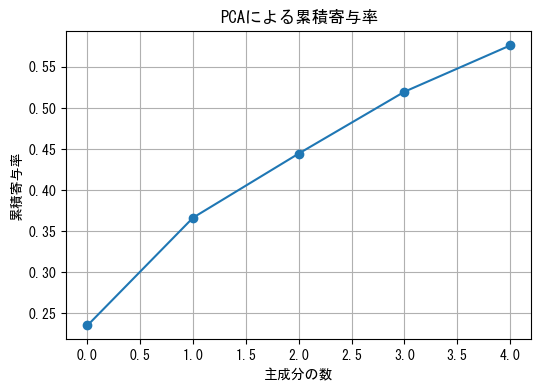

平均二乗誤差 (MSE): 2913.334387676154
決定係数 (R^2): 0.0939042967968805


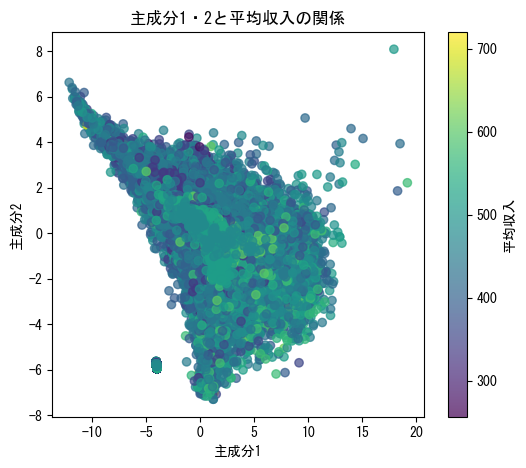

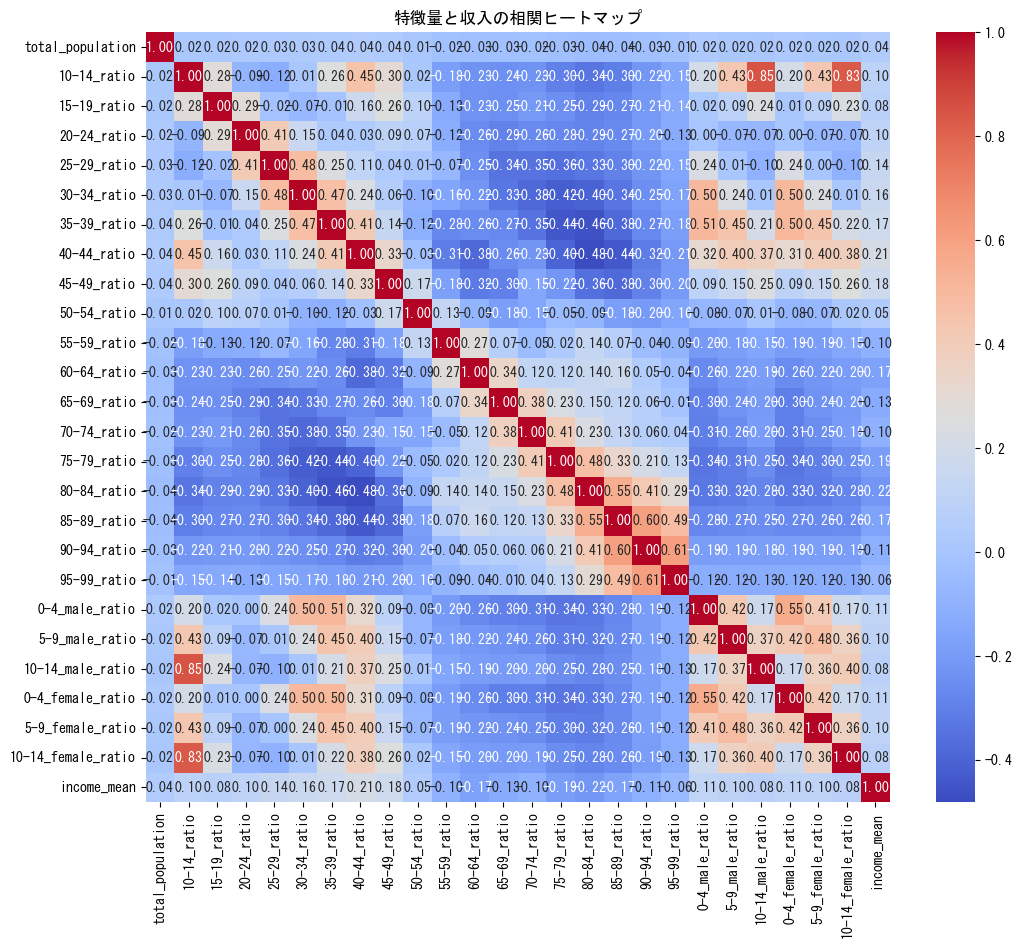

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# 日本語フォントの設定（Windows向け）
plt.rcParams['font.family'] = 'MS Gothic' 
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. データの確認と整形
print("データの基本情報:")
print(merged_df.info())
print("\nデータの一部を表示:")
print(merged_df.head())

# 数値特徴量の選択
feature_cols = [
    'total_population',
    '10-14_ratio', '15-19_ratio', '20-24_ratio', '25-29_ratio',
    '30-34_ratio', '35-39_ratio', '40-44_ratio', '45-49_ratio',
    '50-54_ratio', '55-59_ratio', '60-64_ratio', '65-69_ratio',
    '70-74_ratio', '75-79_ratio', '80-84_ratio', '85-89_ratio',
    '90-94_ratio', '95-99_ratio',
    '0-4_male_ratio', '5-9_male_ratio', '10-14_male_ratio',
    '0-4_female_ratio', '5-9_female_ratio', '10-14_female_ratio',
]

# カテゴリ特徴量のエンコーディング
le = LabelEncoder()
merged_df['max_age_group_encoded'] = le.fit_transform(merged_df['max_age_group_clean'])
feature_cols.append('max_age_group_encoded')

X = merged_df[feature_cols].fillna(0)  # 欠損値を0で補完
y = merged_df['income_mean']

# 2. 特徴量の標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCAによる次元削減（主成分分析）
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print(f"PCAの各主成分の寄与率: {pca.explained_variance_ratio_}")

# 累積寄与率の可視化
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("主成分の数")
plt.ylabel("累積寄与率")
plt.title("PCAによる累積寄与率")
plt.grid(True)
plt.show()

# 4. ランダムフォレスト回帰による収入予測
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 5. モデル評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"平均二乗誤差 (MSE): {mse}")
print(f"決定係数 (R^2): {r2}")

# 6. 可視化：PCAの第1主成分と第2主成分 vs 平均収入
plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="平均収入")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.title("主成分1・2と平均収入の関係")
plt.show()

# 7. 可視化：特徴量と収入の相関ヒートマップ（カテゴリ変数を除く）
plt.figure(figsize=(12,10))
sns.heatmap(merged_df[feature_cols[:-1] + ['income_mean']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("特徴量と収入の相関ヒートマップ")
plt.show()


In [ ]:
print(f"平均二乗誤差 (MSE): {mse}")
print(f"決定係数 (R^2): {r2}")

平均二乗誤差 (MSE): 2913.334387676154
決定係数 (R^2): 0.0939042967968805


平均二乗誤差 (MSE): 2376.35
決定係数 (R^2): 0.2609


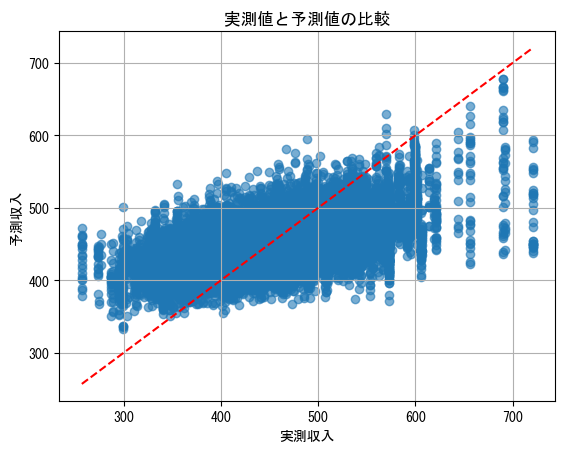

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 特徴量とターゲット設定
feature_cols = [
    'total_population',
    '10-14_ratio', '15-19_ratio', '20-24_ratio', '25-29_ratio',
    '30-34_ratio', '35-39_ratio', '40-44_ratio', '45-49_ratio',
    '50-54_ratio', '55-59_ratio', '60-64_ratio', '65-69_ratio',
    '70-74_ratio', '75-79_ratio', '80-84_ratio', '85-89_ratio',
    '90-94_ratio', '95-99_ratio',
    '0-4_male_ratio', '5-9_male_ratio', '10-14_male_ratio',
    '0-4_female_ratio', '5-9_female_ratio', '10-14_female_ratio',
]

# カテゴリ変数のエンコード
le = LabelEncoder()
merged_df['max_age_group_encoded'] = le.fit_transform(merged_df['max_age_group_clean'])
feature_cols.append('max_age_group_encoded')

X = merged_df[feature_cols].fillna(0)
y = merged_df['income_mean']

# データ分割（8割学習、2割テスト）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル作成＆学習
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 予測と評価
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"平均二乗誤差 (MSE): {mse:.2f}")
print(f"決定係数 (R^2): {r2:.4f}")

# 結果の可視化（実測 vs 予測）
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("実測収入")
plt.ylabel("予測収入")
plt.title("実測値と予測値の比較")
plt.grid(True)
plt.show()
